In [39]:
import pandas as pd
import time
import statsmodels.formula.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tools.tools import add_constant
from sklearn import datasets, linear_model, preprocessing
from sklearn.model_selection import train_test_split
from statsmodels.graphics.gofplots import qqplot
from scipy import stats
from statsmodels.api import add_constant
import statsmodels.api as sm

In [30]:
google_df_import = pd.read_csv("../Data/cleaned.csv",encoding='cp1252')
# google_df = google_df.sample(n=1000, random_state=1) #uncomment to run on sample

In [31]:
google_df = google_df_import.copy()

### preperation

## preliminary analysis

based on: https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/ 

### statistics on variables

Counts and distribution of 3 main variables of interest.

In [4]:
print('Total number of apps = ' + str(len(google_df)))
print(str(len(google_df[google_df.free_app == 1])) + ' free apps, ' + str(len(google_df[google_df.free_app == 0])) + ' paid apps.' + 
      '(' + str(round(len(google_df[google_df.free_app == 1]) / len(google_df) * 100, 1)) + '%, ' + str(round(len(google_df[google_df.free_app == 0]) / len(google_df) * 100, 1)) + '%)')
print(str(len(google_df[google_df.has_ads == 1])) + ' apps with advertisements, ' + str(len(google_df[google_df.has_ads == 0])) + ' apps without ads.' + 
      '(' + str(round(len(google_df[google_df.has_ads == 1]) / len(google_df) * 100, 1)) + '%, ' + str(round(len(google_df[google_df.has_ads == 0]) / len(google_df) * 100, 1)) + '%)')
print(str(len(google_df[google_df.in_app == 1])) + ' apps with in-app purchases, ' + str(len(google_df[google_df.in_app == 0])) + ' apps without in-app purchases.' + 
     '(' + str(round(len(google_df[google_df.in_app == 1]) / len(google_df) * 100, 1)) + '%, ' + str(round(len(google_df[google_df.in_app == 0]) / len(google_df) * 100, 1)) + '%)')

Total number of apps = 775694
714269 free apps, 61425 paid apps.(92.1%, 7.9%)
403456 apps with advertisements, 372238 apps without ads.(52.0%, 48.0%)
90917 apps with in-app purchases, 684777 apps without in-app purchases.(11.7%, 88.3%)


In [11]:
google_df.num_downloads_cat.value_counts()

1000 - 9999        238190
10000 - 99999      207670
100 - 999          150119
100000 - 999999    101051
0 - 99              45590
1000000 +           33047
Name: num_downloads_cat, dtype: int64

In [57]:
google_df[google_df.rating_app == 5].nb_rating.value_counts()

1.0        25662
2.0        15210
3.0         9979
4.0         6743
5.0         4652
           ...  
436.0          1
256.0          1
533.0          1
15337.0        1
207.0          1
Name: nb_rating, Length: 304, dtype: int64

In [4]:
len(google_df[google_df.rating_app == 5])

81109

C:\Users\s164928\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\s164928\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


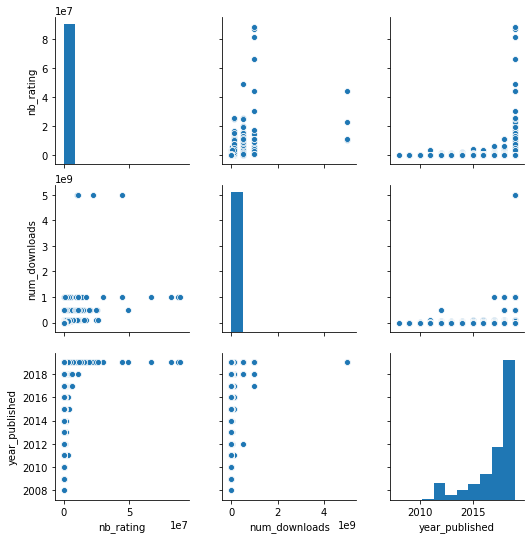

In [7]:
def multiple_displot(data, features):
    sns.pairplot(data[features])
    
features = ['nb_rating', 'num_downloads', 'year_published', 'version']
multiple_displot(google_df, features)

### Correlations between all variables (correlation) (Jari)

In [8]:
def multicollinearity_assumption(google_data):

    from statsmodels.stats.outliers_influence import variance_inflation_factor
        
    # Plotting the heatmap
    plt.figure(figsize = (10,8))
    corr_matrix = google_data.corr()
    print(corr_matrix)
    sns.heatmap(corr_matrix, annot=True)
    plt.title('Correlation of Variables')
    plt.show()

                         rating_app     nb_rating  num_downloads   has_ads  \
rating_app                 1.000000  9.150860e-03       0.004600  0.043729   
nb_rating                  0.009151  1.000000e+00       0.472574  0.009790   
num_downloads              0.004600  4.725743e-01       1.000000  0.005936   
has_ads                    0.043729  9.789553e-03       0.005936  1.000000   
in_app                    -0.000320  3.621102e-02       0.017286  0.141196   
year_published             0.031465  1.800887e-02       0.015027 -0.004571   
age                       -0.031465 -1.800887e-02      -0.015027  0.004571   
PEGI_12                    0.006340  8.150583e-03       0.002529  0.099426   
PEGI_16                   -0.003086  5.020873e-03       0.001896  0.038695   
PEGI_18                   -0.019943  2.608357e-03       0.001887  0.022499   
PEGI_3                    -0.009633 -2.092051e-02      -0.010860 -0.083285   
PEGI_7                    -0.000095  1.511394e-02       0.004985

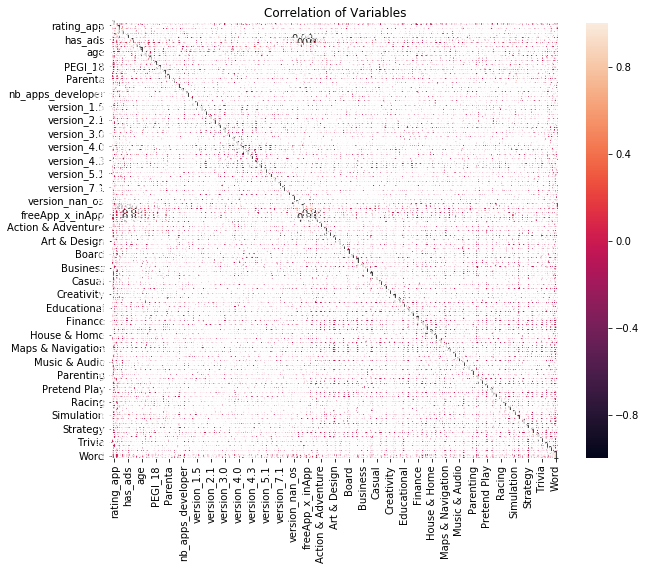

In [9]:
multicollinearity_assumption(google_df)

### autocorelation assumption (jari)

In [110]:
def autocorrelation_assumption(google_df):

    from statsmodels.stats.stattools import durbin_watson
   
    # Calculating residuals for the Durbin Watson-tests
    result = sm.ols(formula="rating_app ~ free_app + has_ads + in_app + nb_rating + freeApp_x_hasAds + num_downloads + freeApp_x_inApp  + freeApp_x_hasAds_inApp", data=google_df).fit()

    print('\nPerforming Durbin-Watson Test')
    print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
    print('0 to 2< is positive autocorrelation')
    print('>2 to 4 is negative autocorrelation')
    print('-------------------------------------')
    durbinWatson = durbin_watson(result.resid)
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation', '\n')
        print('Assumption not satisfied')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation', '\n')
        print('Assumption not satisfied')
    else:
        print('Little to no autocorrelation', '\n')
        print('Assumption satisfied')

In [111]:
autocorrelation_assumption(google_df)


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.627439208746623
Little to no autocorrelation 

Assumption satisfied


### Normal distribution of all variables (Floris)

Shapiro-Swilk test:
Statistics=0.898, p=0.000
Sample does not look Gaussian (reject H0)
-------------------------------------------
D’Agostino’s K^2 Test
Statistics=202911.076, p=0.000
Sample does not look Gaussian (reject H0)
-------------------------------------------
Anderson-Darling Test:


C:\Users\s159907\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Statistic: 16974.077
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)
-------------------------------------------


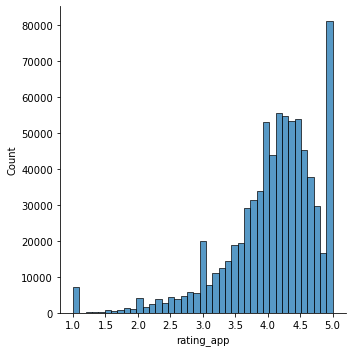

In [14]:
def check_normal_dist(data, target):
    #visualize the distribution
    sns.displot(data, x=str(target), bins = len(data[target].value_counts()))
    #visualize the same distribution, also showing the division in free and paid apps
#     sns.displot(data, x=str(target), bins = len(data[target].value_counts()), hue="free_app", multiple="stack")
    
#     sns.displot(data, x=str(target), bins = len(data[target].value_counts()), hue="in_app", multiple="stack")
#     sns.displot(data, x=str(target), bins = len(data[target].value_counts()), hue="has_ads", multiple="stack")

    # Perform and evaluate three normality tests: Shapiro-Swilk, D’Agostino’s K^2, and Anderson-Darling Test. 
    print('Shapiro-Swilk test:')
    stat, p = stats.shapiro(data[target])
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')
    print('-------------------------------------------')
        
    print('D’Agostino’s K^2 Test')
    stat, p = stats.normaltest(data[target])
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')
    print('-------------------------------------------')
    
    print('Anderson-Darling Test:')
    result = stats.anderson(data[target])
    print('Statistic: %.3f' % result.statistic)
    p = 0
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
        else:
            print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))
    print('-------------------------------------------')
    
check_normal_dist(google_df, 'rating_app')

In [62]:
def normalize_data(data, feature):
    transform = google_df[['rating_app', 'nb_rating']].copy()
    transform = transform.loc[transform.nb_rating > 5]

    transform['box-cox'],_ = stats.boxcox(transform['rating_app'])
    transform['yeojohnson'],_ = stats.yeojohnson(transform['rating_app'])
    check_normal_dist(transform, 'box-cox')
    check_normal_dist(transform, 'yeojohnson')


#     return transform

normalize_data(google_df, 'rating_app')

Shapiro-Swilk test:
Statistics=0.985, p=0.000
Sample does not look Gaussian (reject H0)
-------------------------------------------
D’Agostino’s K^2 Test
Statistics=12952.872, p=0.000
Sample does not look Gaussian (reject H0)
-------------------------------------------
Anderson-Darling Test:
Statistic: 1695.749
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)
-------------------------------------------
Shapiro-Swilk test:
Statistics=0.989, p=0.000
Sample does not look Gaussian (reject H0)
-------------------------------------------
D’Agostino’s K^2 Test
Statistics=11948.100, p=0.000
Sample does not look Gaussian (reject H0)
-------------------------------------------
Anderson-Darling Test:
Statistic: 1598.026
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, 

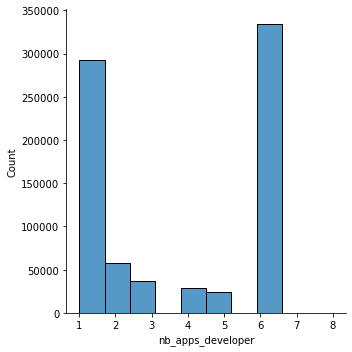

In [17]:
def normalise_function(feature):
    x = google_df[[feature]].values.astype(float)
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_normalized = pd.DataFrame(x_scaled)
    google_df[feature + '_normalized'] = df_normalized
    return google_df

sns.displot(google_df, x=google_df['nb_apps_developer'], bins =10)
normalise_function('nb_apps_developer');

In [18]:
google_df['nb_apps_developer'].value_counts()

6    334571
1    293083
2     57569
3     37326
4     29148
5     23942
8        38
7        17
Name: nb_apps_developer, dtype: int64

In [21]:
check_normal_dist(google_df.loc[google_df.nb_rating > 5], 'rating_app')

Shapiro-Swilk test:
Statistics=0.920, p=0.000
Sample does not look Gaussian (reject H0)
-------------------------------------------
D’Agostino’s K^2 Test
Statistics=128591.307, p=0.000
Sample does not look Gaussian (reject H0)
-------------------------------------------
Anderson-Darling Test:
Statistic: 12053.448
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.656, data does not look normal (reject H0)
5.000: 0.787, data does not look normal (reject H0)
2.500: 0.918, data does not look normal (reject H0)
1.000: 1.092, data does not look normal (reject H0)
-------------------------------------------


### check linearity of variables (Jari)

In [18]:
def linear_assumption(google_df):


    result = sm.ols(formula="rating_app ~ free_app + has_ads + in_app + nb_rating + freeApp_x_hasAds + num_downloads + freeApp_x_inApp  + freeApp_x_hasAds_inApp", data=google_df).fit()
    

    google_df_new = pd.DataFrame(columns=['y_pred', 'y_true'])
    google_df_new['y_pred'] = result.predict()
    google_df_new['y_true'] = google_df.rating_app
    print(google_df_new)
    google_df_new = google_df_new.dropna()

    # Plotting the actual vs predicted values
    sns.lmplot(x = 'y_pred', y = 'y_true',  data = google_df_new)
    plt.title('Actual vs. Predicted')
    plt.ylim(0, 5)
    plt.xlim(0, 5)
    plt.show()

### homoscedasticity assumptions (Floris)

In [27]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

def check_homoscedasticity(target, features, model):
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, target)

    # Plotting the residuals
    plt.subplots(figsize=(12, 6))
    ax = plt.subplot(111)  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residuals')
    plt.show() 

features = []
used_model = ''
check_homoscedasticity(google_df['rating_app'], features, used_model)

AttributeError: 'ellipsis' object has no attribute 'predict'

## Analysis

### Run first OLS for interpretation

In [76]:
column_values = [value for value in google_df.columns]

In [67]:
google_df['log'] = (np.log(google_df['rating_app'])) #0.027 instead of 0.033
google_df['boxcox'],_ = stats.boxcox(google_df['rating_app']) #0.039 instead of 0.033
google_df['yeojohnson'],_ = stats.yeojohnson(google_df['rating_app']) #0.039 instead of 0.033

In [73]:
#with non-significant values
result = sm.ols(formula=
                "rating_app ~ free_app + nb_rating+ age + PEGI_12 + PEGI_16 + PEGI_18 + PEGI_3 + PEGI_7 + Parenta + Unrated + nb_apps_developer + Action+ ActionANDAdventure+ Adventure+ Arcade+ ActionANDAdventure+ AutoANDVehicles+ Beauty+ Board+ BooksANDReference+ BrainGames+ Business+ Card+ Casino+ Casual+ Comics+ Communication+ Creativity+ Dating+ Education+ Educational+ Entertainment+ Events+ Finance+ FoodANDDrink+ HealthANDFitness+ HouseANDHome+ LibrariesANDDemo+ Lifestyle+ MapsANDNavigation+ Medical+ Music+ MusicANDAudio+ MusicANDVideo+ NewsANDMagazines+ Parenting+ Personalization+ Photography+ PretendPlay+ Productivity+ Puzzle+Racing+ RolePlaying+ Shopping+ Simulation+ Social+ Sports+ Strategy+ Tools+ TravelANDLocal+ Trivia+ VideoPlayersANDEditors+ Weather+ Word + version_1_0+ version_1_1+ version_1_5+ version_1_6+ version_2_0+ version_2_1+ version_2_2+ version_2_3+ version_3_0+ version_3_1+ version_3_2+ version_4_0+ version_4_1+ version_4_2+ version_4_3+ version_4_4+ version_5_0+ version_5_1+ version_6_0+ version_7_0+ version_7_1+ version_8_0+ version_Var+ version_nan_os", data=google_df).fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             rating_app   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     300.2
Date:                Wed, 11 Nov 2020   Prob (F-statistic):               0.00
Time:                        20:35:08   Log-Likelihood:            -8.4396e+05
No. Observations:              775693   AIC:                         1.688e+06
Df Residuals:                  775606   BIC:                         1.689e+06
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  3

In [75]:
#non-significance removed
result = sm.ols(formula=
                "rating_app ~ free_app + nb_rating+ age + PEGI_12 + PEGI_16 + PEGI_18 + PEGI_3 + PEGI_7 + Parenta + Unrated + nb_apps_developer + Parenting+version_1_0+  version_1_5+ version_1_6+ version_2_0+ version_2_1+ version_2_2+ version_2_3+ version_3_0+ version_3_1+ version_3_2+ version_4_0+ version_4_1+ version_4_2+ version_4_3+ version_4_4+ version_5_0+ version_5_1+ version_8_0+ version_Var", data=google_df).fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             rating_app   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     180.7
Date:                Wed, 11 Nov 2020   Prob (F-statistic):               0.00
Time:                        20:35:44   Log-Likelihood:            -8.5396e+05
No. Observations:              775693   AIC:                         1.708e+06
Df Residuals:                  775662   BIC:                         1.708e+06
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             3.3940      0.01

# Poisson

In [36]:
#Make a count variable from rating so poisson can be used.
google_df['rating_app_rounded'] = google_df.rating_app.apply(lambda x: round(x))
y = google_df.rating_app_rounded
X = google_df[['free_app','in_app', 'has_ads',  'PEGI_12', 'PEGI_16', 'PEGI_18', 'PEGI_3', 'PEGI_7', 'Parenta', 'Unrated', 'version_1_0', 'version_1_1', 'version_1_5', 'version_1_6', 'version_2_0', 'version_2_1', 'version_2_2', 'version_2_3', 'version_3_0', 'version_3_1', 'version_3_2', 'version_4_0', 'version_4_1', 'version_4_2', 'version_4_3', 'version_4_4', 'version_5_0', 'version_5_1', 'version_6_0', 'version_7_0', 'version_7_1', 'version_8_0', 'version_Var', 'Action', 'ActionANDAdventure', 'Adventure', 'Arcade', 'AutoANDVehicles', 'Beauty', 'Board', 'BooksANDReference', 'BrainGames', 'Business', 'Card', 'Casino', 'Casual', 'Comics', 'Communication', 'Creativity', 'Dating', 'Education', 'Educational', 'Entertainment', 'Events', 'Finance', 'FoodANDDrink', 'HealthANDFitness', 'HouseANDHome', 'LibrariesANDDemo', 'Lifestyle', 'MapsANDNavigation', 'Medical', 'Music', 'MusicANDAudio', 'MusicANDVideo', 'NewsANDMagazines', 'Parenting', 'Personalization', 'Photography', 'PretendPlay', 'Productivity', 'Puzzle', 'Racing', 'RolePlaying', 'Shopping', 'Simulation', 'Social', 'Sports', 'Strategy', 'Tools', 'TravelANDLocal', 'Trivia', 'VideoPlayersANDEditors', 'Weather', 'Word']]
X = add_constant(X)

In [37]:
res = sm.GLM(y.astype(float), X.astype(float), family = sm.families.Poisson()).fit()
print(res.summary())

#Chisqaured: 1.11e+05 > 107.52 so the 0 hypothesis is rejected

                 Generalized Linear Model Regression Results                  
Dep. Variable:     rating_app_rounded   No. Observations:               775694
Model:                            GLM   Df Residuals:                   775608
Model Family:                 Poisson   Df Model:                           85
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.3265e+06
Date:                Thu, 12 Nov 2020   Deviance:                   1.2386e+05
Time:                        16:29:49   Pearson chi2:                 1.11e+05
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1

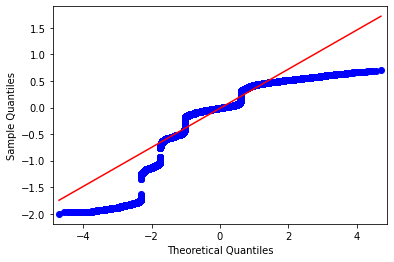

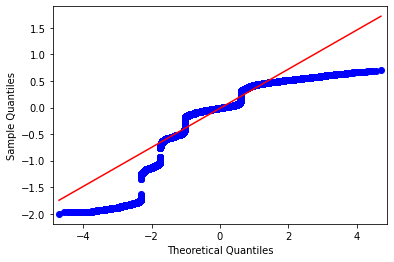

In [38]:
from statsmodels.graphics.api import abline_plot
from statsmodels import graphics

resid = res.resid_deviance.copy()
graphics.gofplots.qqplot(resid, line='r')